In [46]:
# Preanalisis jc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Carga robusta (ajusta sep si el txt son TSV)
df1 = pd.read_csv("df_final_web_data_pt_1.txt", sep=None, engine="python")
df2 = pd.read_csv("df_final_web_data_pt_2.txt", sep=None, engine="python")

df = pd.concat([df1, df2], ignore_index=True)

In [47]:
# 2) Limpieza base: espacios en columnas y tipos
df.columns = df.columns.str.strip()

# Normalizar process_step temprano
df["process_step"] = (
    df["process_step"]
    .astype(str)
    .str.strip()
    .str.lower()
)


In [48]:
# 3) Fecha a datetime
df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")


In [49]:
# 4) Nulos y duplicados (dos niveles)
nulls = df.isna().sum().sort_values(ascending=False)
dups_full = df.duplicated().sum()

In [50]:
# duplicado "lógico" de evento (ajusta columnas si alguna no existe)
key_cols = [c for c in ["visit_id", "visitor_id", "date_time", "process_step"] if c in df.columns]
dups_event = df.duplicated(subset=key_cols).sum()

print("Rows:", df.shape[0])
print("Full duplicated rows:", dups_full)
print("Event-duplicated rows (subset):", dups_event)
print("\nTop nulls:\n", nulls.head(10))

# Si quieres eliminar duplicados, suele ser más seguro por subset:
if dups_event > 0:
    df = df.drop_duplicates(subset=key_cols)

Rows: 755405
Full duplicated rows: 10764
Event-duplicated rows (subset): 10764

Top nulls:
 client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64


In [51]:
# 5) Orden y tiempos entre eventos por visita
df = df.sort_values(["visit_id", "date_time"])

df["time_diff"] = df.groupby("visit_id")["date_time"].diff()
df["time_diff_sec"] = df["time_diff"].dt.total_seconds()

neg = (df["time_diff_sec"] < 0).sum()
print("Negative time diffs:", neg)

Negative time diffs: 0


In [52]:
# 6) Métricas por visita/sesión (esto es lo más valioso para el equipo)
session = df.groupby("visit_id").agg(
    session_start=("date_time", "min"),
    session_end=("date_time", "max"),
    n_events=("process_step", "size"),
    n_unique_steps=("process_step", "nunique")
).reset_index()

session["session_duration_sec"] = (session["session_end"] - session["session_start"]).dt.total_seconds()

In [53]:
# define completion (ajusta si el dataset usa otro nombre, ej. "confirm")
completion_step_candidates = ["confirm", "confirmation", "complete", "completed"]
df_steps = df.groupby("visit_id")["process_step"].apply(set)

session["completed"] = session["visit_id"].map(
    lambda vid: any(x in df_steps.loc[vid] for x in completion_step_candidates) if vid in df_steps.index else False
)

session["bounce"] = session["n_events"].eq(1)

session.describe(include="all")

,visit_id,session_start,session_end,n_events,n_unique_steps,session_duration_sec,completed,bounce
count,158095,158095,158095,158095.000000,158095.000000,158095.000000,158095,158095
unique,158095,NaN,NaN,NaN,NaN,NaN,2,2
top,100012776_37918976071_457913,NaN,NaN,NaN,NaN,NaN,True,False
freq,1,NaN,NaN,NaN,NaN,NaN,89826,133075
mean,NaN,2017-05-06 18:19:46.645782784,2017-05-06 18:25:04.321167616,4.710086,3.500534,317.675385,NaN,NaN
min,NaN,2017-03-15 00:03:03,2017-03-15 00:03:03,1.000000,1.000000,0.000000,NaN,NaN
25%,NaN,2017-04-08 01:29:47,2017-04-08 01:33:14.500000,2.000000,2.000000,42.000000,NaN,NaN
50%,NaN,2017-05-07 12:36:30,2017-05-07 12:38:16,5.000000,4.000000,171.000000,NaN,NaN
75%,NaN,2017-06-02 18:34:55.500000,2017-06-02 18:40:54.500000,6.000000,5.000000,362.000000,NaN,NaN
max,NaN,2017-06-20 23:59:57,2017-06-20 23:59:57,61.000000,5.000000,42768.000000,NaN,NaN


Session duration percentiles:
 0.50     171.00
0.90     722.00
0.95    1104.00
0.99    2508.06
Name: session_duration_sec, dtype: float64


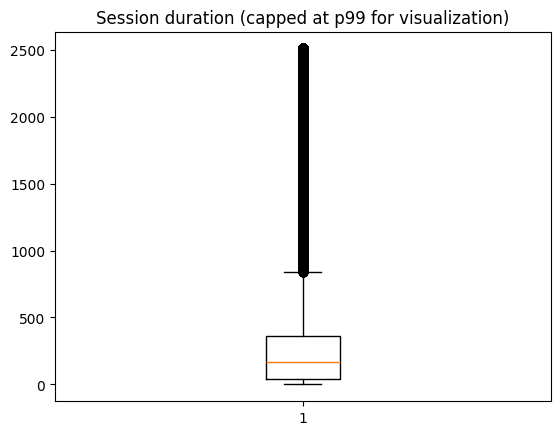

In [54]:
# 7) Percentiles para entender outliers (mejor que solo boxplot)
q = session["session_duration_sec"].dropna().quantile([.5,.9,.95,.99])
print("Session duration percentiles:\n", q)

# Boxplot (cap visual opcional para que se vea algo)
cap = session["session_duration_sec"].quantile(0.99)
plt.boxplot(session["session_duration_sec"].clip(upper=cap).dropna())
plt.title("Session duration (capped at p99 for visualization)")
plt.show()

In [55]:
# 8) Exportar dos salidas
df.to_csv("df_web_events_clean.csv", index=False)
session.to_csv("df_web_session_summary.csv", index=False)

In [56]:
df.head()

,client_id,visitor_id,visit_id,process_step,date_time,time_diff,time_diff_sec
108614,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,NaT,NaN
108613,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,0 days 00:00:52,52.0
447951,9056452,306992881_89423906595,1000165_4190026492_760066,start,2017-06-04 01:07:29,NaT,NaN
447950,9056452,306992881_89423906595,1000165_4190026492_760066,step_1,2017-06-04 01:07:32,0 days 00:00:03,3.0
447949,9056452,306992881_89423906595,1000165_4190026492_760066,step_2,2017-06-04 01:07:56,0 days 00:00:24,24.0


In [57]:
# cuantas confirmaciones repetidas hay
confirm_counts = df[df["process_step"] == "confirm"] \
    .groupby("visit_id") \
    .size() \
    .value_counts()

print(confirm_counts)


1     80903
2      6794
3      1375
4       408
5       121
8        83
6        62
7        60
9        12
10        5
11        1
15        1
13        1
Name: count, dtype: int64


In [58]:
# Marcar conversión correctamente (una vez por sesión)
session = df.groupby("visit_id").agg(
    session_start=("date_time", "min"),
    session_end=("date_time", "max"),
    n_events=("process_step", "size"),
)

session["session_duration_sec"] = (
    session["session_end"] - session["session_start"]
).dt.total_seconds()

# Conversión real (boolean)
session["completed"] = df.groupby("visit_id")["process_step"] \
    .apply(lambda x: "confirm" in set(x))

session.head()


,session_start,session_end,n_events,session_duration_sec,completed
visit_id,,,,,
100012776_37918976071_457913,2017-04-26 13:22:17,2017-04-26 13:23:09,2,52.0,True
1000165_4190026492_760066,2017-06-04 01:07:29,2017-06-04 01:09:50,5,141.0,True
100019538_17884295066_43909,2017-04-09 16:20:56,2017-04-09 16:24:58,11,242.0,True
100022086_87870757897_149620,2017-05-23 20:44:01,2017-05-23 20:47:01,5,180.0,True
100030127_47967100085_936361,2017-03-22 11:07:49,2017-03-22 11:07:49,1,0.0,False


In [59]:
# Detectar sesiones raras

# Sesiones que empiezan sin start
df.groupby("visit_id")["process_step"].first().value_counts()

# Sesiones que tienen confirm pero no start
df.groupby("visit_id")["process_step"] \
  .apply(lambda x: "confirm" in x.values and "start" not in x.values) \
  .sum()


np.int64(12496)

### El grupo test tiene más confirmaciones repetidas que el control?

Si sí → el rediseño podría estar generando fricción o errores.

In [ ]:
df.to_csv("df_web_events_final.csv", index=False)
